In [1]:
import sys
import os
import requests
import datetime
from pathlib import Path
#
path_root = Path(os.path.abspath(''))
sys.path.insert(1, os.path.join(path_root))
#
path_root2 = Path(os.path.abspath('')).parent
sys.path.insert(1, os.path.join(path_root2))

import time
import talib
import sqlite3 as sqlite3
import numpy as np
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
from util.util import get_ucodes
from pypfopt import risk_models, expected_returns, efficient_frontier, plotting, objective_functions

path_sqlite = os.path.join(path_root, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')
if not os.path.exists(path_sqlite):
    path_sqlite = os.path.join(path_root2, 'data', 'aastock', 'sqlite', 'hk-marketwatch.db')

cur_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
temp_path = os.path.join(path_root, '現代資產組合', cur_time)
Path(temp_path).mkdir(parents=True, exist_ok=True)

In [2]:
conn = sqlite3.connect(path_sqlite)
cursor = conn.cursor()

data = {}
ucodes = ['hsi', 'hsce', 'ssec', 'ixic', 'sp500', 'n225', 'twii', 'ks11', 'gdaxi', 'fchi', 'ftse']
for ucode in ucodes:
    if '.HK' in ucode:
        ucode = ucode.replace('.HK', '').zfill(5)
    if '.SS' in ucode or '.SZ' in ucode:
        ucode = ucode.replace('.SS', '').replace('.SZ', '').zfill(6)
    
    #
    sql = """SELECT t.code, t.lot, t.nmll, t.stime, t.high, t.low, t.open, t.close, t.volume
                FROM (SELECT n.code, n.lot, n.nmll, c.stime, c.high, c.low, c.open, c.close, c.volume 
                    FROM s_{} AS c INNER JOIN name AS n 
                        ON c.code=n.code ORDER BY c.stime DESC) AS t 
                            ORDER BY t.stime """.format(ucode)
    cursor.execute(sql)
    columns = ['code', 'lot', 'nmll', 'sdate', 'high', 'low', 'open', 'last', 'vol']
    data[ucode] = pd.DataFrame(cursor.fetchall(), columns=columns)
    data[ucode].index = pd.to_datetime(data[ucode].sdate)
    print(f"{ucode}:   {data[ucode].index[0]} ~ {data[ucode].index[-1]}  {data[ucode].shape}")
conn.close()

hsi:   1986-12-31 00:00:00 ~ 2021-08-19 00:00:00  (8521, 9)
hsce:   1993-07-15 00:00:00 ~ 2021-08-19 00:00:00  (6884, 9)
ssec:   1992-05-08 00:00:00 ~ 2021-08-19 00:00:00  (7217, 9)
ixic:   1971-02-05 00:00:00 ~ 2021-08-19 00:00:00  (12386, 9)
sp500:   1927-12-30 00:00:00 ~ 2021-08-19 00:00:00  (19669, 9)
n225:   1965-01-05 00:00:00 ~ 2021-08-19 00:00:00  (13705, 9)
twii:   1997-07-02 00:00:00 ~ 2021-08-19 00:00:00  (5922, 9)
ks11:   1996-12-11 00:00:00 ~ 2021-08-19 00:00:00  (6084, 9)
gdaxi:   1987-12-30 00:00:00 ~ 2021-08-18 00:00:00  (8476, 9)
fchi:   1990-03-01 00:00:00 ~ 2021-08-18 00:00:00  (7980, 9)
ftse:   1984-01-03 00:00:00 ~ 2021-08-18 00:00:00  (9559, 9)


In [3]:
data_all = []
nmll = []
for k, df in data.items():
    data_all.append(df['last'])
    nmll.append(k)
df2 = pd.concat(data_all, axis=1)
df2 = df2.dropna()
df2.columns = nmll
print(f"{df2.index[0]} ~ {df2.index[-1]}  {df2.shape}")

1997-07-03 00:00:00 ~ 2021-08-17 00:00:00  (4908, 11)


In [4]:
start_year = list(dict.fromkeys(df2.index.year.values))[1]

相關系數 1998年起


,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse
hsi,1.000000,0.879610,0.801761,0.711366,0.757170,0.591387,0.771087,0.933404,0.864313,0.495237,0.759426
hsce,0.879610,1.000000,0.817051,0.403625,0.449136,0.245422,0.539040,0.855718,0.592350,0.166008,0.474094
ssec,0.801761,0.817051,1.000000,0.497532,0.535101,0.417416,0.571671,0.736035,0.662963,0.440003,0.518725
ixic,0.711366,0.403625,0.497532,1.000000,0.985797,0.841955,0.902516,0.748609,0.904344,0.580942,0.652819
sp500,0.757170,0.449136,0.535101,0.985797,1.000000,0.863313,0.895339,0.777654,0.943091,0.616380,0.729907
n225,0.591387,0.245422,0.417416,0.841955,0.863313,1.000000,0.841175,0.534429,0.822003,0.740991,0.760920
twii,0.771087,0.539040,0.571671,0.902516,0.895339,0.841175,1.000000,0.784893,0.868344,0.552745,0.717142
ks11,0.933404,0.855718,0.736035,0.748609,0.777654,0.534429,0.784893,1.000000,0.849202,0.361298,0.656907
gdaxi,0.864313,0.592350,0.662963,0.904344,0.943091,0.822003,0.868344,0.849202,1.000000,0.639164,0.849539
fchi,0.495237,0.166008,0.440003,0.580942,0.616380,0.740991,0.552745,0.361298,0.639164,1.000000,0.735103


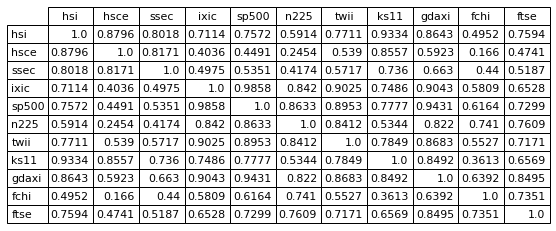

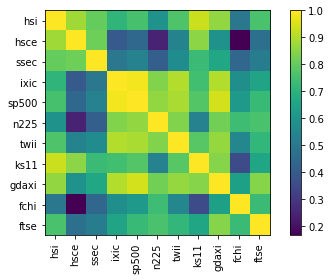

In [5]:
# 相關系數
print(f'相關系數 {start_year}年起')

ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
table = pd.plotting.table(ax, df2.corr().round(4), loc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.5, 1.5)
plt.savefig(os.path.join(temp_path, 'correlation_coefficient_2.png'), bbox_inches="tight")

plotting.plot_covariance(df2.corr(), plot_correlation=False, filename=os.path.join(temp_path, 'correlation_coefficient_1.png'))

df2.corr()

均方差 1998年起      (4908, 11)


,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse
hsi,0.078737,0.084312,0.027392,0.022316,0.017393,0.039968,0.035614,0.045468,0.030046,0.030369,0.026107
hsce,0.084312,0.147699,0.040041,0.021660,0.017977,0.044250,0.040295,0.051610,0.028949,0.030132,0.027269
ssec,0.027392,0.040041,0.071883,0.005639,0.004556,0.015911,0.014737,0.014170,0.007936,0.008408,0.007402
ixic,0.022316,0.021660,0.005639,0.078301,0.054204,0.015638,0.015972,0.020474,0.043505,0.039369,0.029753
sp500,0.017393,0.017977,0.004556,0.054204,0.047248,0.013066,0.011582,0.015557,0.036355,0.033747,0.027003
n225,0.039968,0.044250,0.015911,0.015638,0.013066,0.066209,0.029349,0.039689,0.024825,0.025818,0.020892
twii,0.035614,0.040295,0.014737,0.015972,0.011582,0.029349,0.059395,0.036699,0.018752,0.019071,0.015789
ks11,0.045468,0.051610,0.014170,0.020474,0.015557,0.039689,0.036699,0.089269,0.025617,0.024783,0.021196
gdaxi,0.030046,0.028949,0.007936,0.043505,0.036355,0.024825,0.018752,0.025617,0.069364,0.059934,0.043827
fchi,0.030369,0.030132,0.008408,0.039369,0.033747,0.025818,0.019071,0.024783,0.059934,0.063826,0.045461


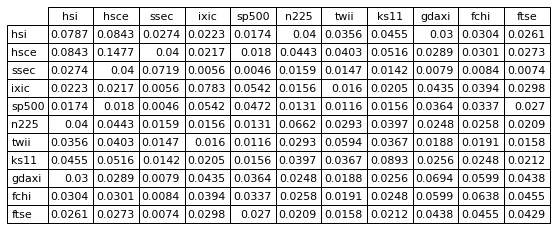

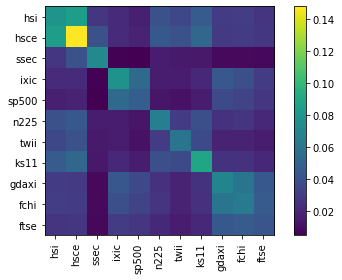

In [6]:
# 標準差
print(f'均方差 {start_year}年起      {df2.shape}')

ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
table = pd.plotting.table(ax, risk_models.sample_cov(df2).round(4), loc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.5, 1.5)
plt.savefig(os.path.join(temp_path, 'mean_square_error_2.png'), bbox_inches="tight")

plotting.plot_covariance(risk_models.sample_cov(df2), plot_correlation=False, show_tickers=True, filename=os.path.join(temp_path, 'mean_square_error_1.png'))
risk_models.sample_cov(df2)

In [7]:
def simulate(df7):
    df7_1 = pd.DataFrame(columns=df7.columns)
    df7_1['Date'] = df7['Date']
    for v in df7.columns[1:]:
        cur_money = 10000
        no = 1
        for v1 in df7[v]:
            data2 = cur_money * (v1 / 100)
            cur_money = cur_money + data2
            df7_1.loc[no, v] = cur_money
            no = no + 1
    return df7_1

In [8]:
# 年度
df3_1 = df2.copy(deep=True)
df3 = pd.DataFrame(columns=['Date']+df3_1.columns.to_list())
for year in range(start_year, 2022, 1):
    df3_2 = df3_1[f'{year}-01-01': f'{year}-12-31'].iloc[[0, -1]].pct_change()*100
    df3.loc[df3.shape[0]+1] = [f'{year}-01-01 ~ {year}-12-31']+df3_2.iloc[-1].to_list()
print(f'年度標準差(風險)  {start_year}年起')
print(df3.std())
print('年度收益率(回報)')
df3_2 = simulate(df3)
for k in ucodes:
    plt.tight_layout()
    plt.rcParams.update({'font.size': 9})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5.5), facecolor='white')
    
    ax1.barh(df3['Date'], df3[k], height=0.5, align='center')
    ax1.set_title(k+' Yearly Expected Return')
    ax1.grid()
    
    ax2.barh(df3_2['Date'], df3_2[k], height=0.5, align='center', tick_label=[''])
    ax2.set_title(k+' Yearly Cumulative Expected Return')
    ax2.grid()
    
    plt.savefig(os.path.join(temp_path, k+'_YearlyExpectedReturn.png'), bbox_inches='tight')
    plt.close(fig)
    # ax = df3.plot.barh(x='Date', y=k, figsize=(6,5), grid=True)
    # ax2 = df3_2.plot.barh(x='Date', y=k, figsize=(6,5), grid=True)
df3

年度標準差(風險)  1998年起
hsi      25.120051
hsce     41.042971
ssec     41.245836
ixic     27.316097
sp500    16.099432
n225     23.065416
twii     24.756722
ks11     27.802016
gdaxi    20.448753
fchi     19.311904
ftse     13.627769
dtype: float64
年度收益率(回報)


,Date,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse
1,1998-01-01 ~ 1998-12-31,0.184982,-44.142703,-2.826780,33.050209,23.181547,-7.871915,-15.518832,38.149768,10.471479,24.331877,11.036576
2,1999-01-01 ~ 1999-12-31,63.707440,20.222722,23.921334,74.892395,15.372192,39.517057,30.074771,67.798809,23.352154,33.815394,12.930077
3,2000-01-01 ~ 2000-12-31,-13.674427,-24.985475,47.170847,-35.488979,-6.679202,-29.341791,-45.055759,-52.730776,-5.094168,1.969492,-8.526979
4,2001-01-01 ~ 2001-12-31,-24.965099,4.499286,-22.571072,-22.579214,-12.923932,-22.998739,5.104036,24.314539,-19.076802,-20.485078,-15.248322
5,2002-01-01 ~ 2002-12-31,-20.763879,9.707247,-15.206153,-34.954204,-24.999360,-21.087634,-20.941271,-16.071522,-45.614275,-35.398772,-26.732780
6,2003-01-01 ~ 2003-12-31,29.596442,138.485771,13.262522,41.409400,19.443279,22.532253,25.094343,21.598595,25.589038,9.934053,11.720898
7,2004-01-01 ~ 2004-12-31,8.905731,-12.664340,-18.786844,6.397512,8.138340,6.130064,-0.400955,8.714963,5.455541,6.087646,6.797694
8,2005-01-01 ~ 2005-12-31,7.117304,13.636099,-5.866874,5.232786,5.586465,41.904454,8.498848,55.527112,27.224801,23.545418,16.325558
9,2006-01-01 ~ 2006-12-31,31.590998,86.055627,117.415276,7.162049,11.878663,5.276218,16.874491,2.307235,19.700666,14.360586,9.211492
10,2007-01-01 ~ 2007-12-31,39.036820,57.987258,95.487426,9.103994,4.084356,-10.308940,4.779242,36.594404,20.439294,0.949311,3.352947


<Figure size 432x288 with 0 Axes>

累計 年化收益率


,Date,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse
1,1998-01-01 ~ 1998-12-31,0.184982,-44.142703,-2.826780,33.050209,23.181547,-7.871915,-15.518832,38.149768,10.471479,24.331877,11.036576
2,1999-01-01 ~ 1999-12-31,64.010268,-32.846838,20.418351,132.694696,42.117250,28.534393,9.888686,131.813664,36.268949,66.375191,25.393691
3,2000-01-01 ~ 2000-12-31,41.582804,-49.625374,77.220706,50.113724,32.624952,-9.179900,-39.622495,9.576520,29.327180,69.651937,14.701397
4,2001-01-01 ~ 2001-12-31,6.236516,-47.358875,37.220092,16.219225,15.484594,-30.067378,-36.540806,36.219545,4.655689,34.898605,-2.788641
5,2002-01-01 ~ 2002-12-31,-15.822305,-42.248872,16.354195,-24.404280,-13.385815,-44.814513,-49.829967,14.326990,-43.082244,-12.853844,-28.775940
6,2003-01-01 ~ 2003-12-31,9.091298,37.728224,31.785695,6.899454,3.454822,-32.379979,-37.240127,39.020014,-28.517538,-4.196699,-20.427840
7,2004-01-01 ~ 2004-12-31,18.806676,20.285853,7.027321,13.738359,11.874327,-28.234829,-37.491766,51.135557,-24.617783,1.635466,-15.018769
8,2005-01-01 ~ 2005-12-31,27.262508,36.688151,0.748163,19.690044,18.124147,1.837974,-32.179286,135.056767,-4.095124,25.565961,-1.145109
9,2006-01-01 ~ 2006-12-31,67.466005,154.315997,119.041897,28.262303,32.155717,7.211167,-20.734886,140.480079,14.798775,43.597969,7.960901
10,2007-01-01 ~ 2007-12-31,132.839408,301.786870,328.199367,39.939295,37.553427,-3.841168,-16.946614,228.482330,38.262834,44.961161,11.580774


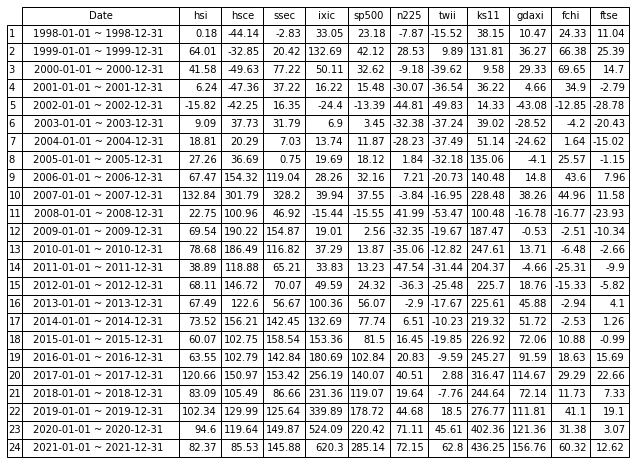

In [38]:
# 累計 年化收益率
df4 = pd.DataFrame(columns=df3.columns.to_list())
df4['Date'] = df3['Date']
for code in data.keys():
    annualized_total_return = 1
    annualized_total_returns = []
    # 每年
    for v in df3[code]:
        annualized_total_return = annualized_total_return * (1+(v/100))
        annualized_total_returns.append((annualized_total_return-1))
    df4[code] = annualized_total_returns
    
for code in data.keys():
    df4[code] = df4[code]*100

no_year = df4.shape[0]
start_year_4 = df4['Date'].iloc[0].split('~')[0].replace(' ', '')
end_year_4 = df4['Date'].iloc[-1].split('~')[0].replace(' ', '')
    
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
table = pd.plotting.table(ax, df4.round(2), loc='center')
table.auto_set_column_width(col=list(range(len(df4.columns))))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(2, 1.5)
plt.savefig(os.path.join(temp_path, f'annualized_return_nearly_{no_year}_years.png'), bbox_inches="tight")
    
print(f'累計 年化收益率')
df4

In [10]:
print("每日收市價 标准差")
df2_1 = pd.DataFrame()
for ucode in ucodes:
    d1 = stats.describe(df2[ucode].values)
    d2 = np.std(df2[ucode].values)
    d3 = np.mean(df2[ucode].values)
    
    d4_1 = [.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
    d4 = df2[ucode].quantile(d4_1).values.tolist()
    
    sd_map = [
        [0.318639, 0.25],
        [0.674490, 0.50],
        [1, 0.68268],
        [1.281552, 0.80],
        [2, 0.95449],
        [3, 0.99730]
    ]
    no_year = ((df2[ucode].index[-1] - df2[ucode].index[0])/np.timedelta64(1, 'Y'))
    content = f'{ucode} | '
    for v in sd_map:
        content = content+"{:.2f}年 ±{:.0f} {:.2f}% | ".format(no_year*v[1], d2*v[0], d2*v[0]/d3*100)
    print(content)
    
    df2_1 = df2_1.append(pd.Series([ucode, d1.skewness, d1.kurtosis, d2, "{:.3f}%".format(d2/d3*100), content]), ignore_index=True)
df2_1.columns=['标的', '峰度', '偏态', '标准差', '相对标准偏差', 'x年一遇±']
df2_1

每日收市價 标准差
hsi | 6.03年 ±1962 10.17% | 12.06年 ±4154 21.53% | 16.47年 ±6159 31.93% | 19.30年 ±7893 40.91% | 23.03年 ±12317 63.85% | 24.06年 ±18476 95.78% | 
hsce | 6.03年 ±1313 16.45% | 12.06年 ±2779 34.83% | 16.47年 ±4120 51.63% | 19.30年 ±5280 66.17% | 23.03年 ±8241 103.27% | 24.06年 ±12361 154.90% | 
ssec | 6.03年 ±292 12.21% | 12.06年 ±618 25.84% | 16.47年 ±916 38.31% | 19.30年 ±1174 49.09% | 23.03年 ±1832 76.62% | 24.06年 ±2749 114.92% | 
ixic | 6.03年 ±894 23.05% | 12.06年 ±1893 48.80% | 16.47年 ±2806 72.35% | 19.30年 ±3597 92.72% | 23.03年 ±5613 144.70% | 24.06年 ±8419 217.04% | 
sp500 | 6.03年 ±244 14.63% | 12.06年 ±516 30.97% | 16.47年 ±765 45.92% | 19.30年 ±980 58.85% | 23.03年 ±1529 91.85% | 24.06年 ±2294 137.77% | 
n225 | 6.03年 ±1587 10.44% | 12.06年 ±3360 22.10% | 16.47年 ±4981 32.77% | 19.30年 ±6384 42.00% | 23.03年 ±9963 65.54% | 24.06年 ±14944 98.31% | 
twii | 6.03年 ±765 9.40% | 12.06年 ±1619 19.91% | 16.47年 ±2401 29.51% | 19.30年 ±3077 37.82% | 23.03年 ±4802 59.03% | 24.06年 ±7203 88.54% | 
ks11 | 6.03年 ±218

,标的,峰度,偏态,标准差,相对标准偏差,x年一遇±
0,hsi,-0.064014,-1.099920,6158.577390,31.925%,hsi | 6.03年 ±1962 10.17% | 12.06年 ±4154 21.53%...
1,hsce,-0.263820,-1.113440,4120.384877,51.635%,hsce | 6.03年 ±1313 16.45% | 12.06年 ±2779 34.83...
2,ssec,0.682804,0.493609,916.207588,38.308%,ssec | 6.03年 ±292 12.21% | 12.06年 ±618 25.84% ...
3,ixic,1.832064,3.166567,2806.485467,72.348%,ixic | 6.03年 ±894 23.05% | 12.06年 ±1893 48.80%...
4,sp500,1.426911,1.500522,764.746876,45.923%,sp500 | 6.03年 ±244 14.63% | 12.06年 ±516 30.97%...
5,n225,0.575812,-0.199695,4981.454896,32.769%,n225 | 6.03年 ±1587 10.44% | 12.06年 ±3360 22.10...
6,twii,1.188894,2.757788,2400.963099,29.514%,twii | 6.03年 ±765 9.40% | 12.06年 ±1619 19.91% ...
7,ks11,0.015225,-0.825045,683.767205,44.812%,ks11 | 6.03年 ±218 14.28% | 12.06年 ±461 30.23% ...
8,gdaxi,0.623403,-0.708744,3185.162619,41.983%,gdaxi | 6.03年 ±1015 13.38% | 12.06年 ±2148 28.3...
9,fchi,0.224359,-0.728355,948.402318,21.287%,fchi | 6.03年 ±302 6.78% | 12.06年 ±640 14.36% |...


In [11]:
print("年度收益率 标准差")
df2_2 = pd.DataFrame()
for ucode in ucodes:
    d1 = stats.describe(df3[ucode].values)
    d2 = np.std(df3[ucode].values)
    d3 = np.mean(df3[ucode].values)
    
    d4_1 = [.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
    d4 = df3[ucode].quantile(d4_1).values.tolist()
    
    sd_map = [
        [0.318639, 0.25],
        [0.674490, 0.50],
        [1, 0.68268],
        [1.281552, 0.80],
        [2, 0.95449],
        [3, 0.99730]
    ]
    no_year = df3.shape[0]
    content = f'{ucode} | '
    for v in sd_map:
        content = content+"{:.2f}年 ±{:.2f}% | ".format(no_year*v[1], d2*v[0])
    print(content)
    
    df2_2 = df2_2.append(pd.Series([ucode, d1.skewness, d1.kurtosis, d2, content]), ignore_index=True)
df2_2.columns=['标的', '峰度', '偏态', '标准差', 'x年一遇±']
df2_2

年度收益率 标准差
hsi | 6.00年 ±7.84% | 12.00年 ±16.59% | 16.38年 ±24.59% | 19.20年 ±31.51% | 22.91年 ±49.18% | 23.94年 ±73.77% | 
hsce | 6.00年 ±12.80% | 12.00年 ±27.10% | 16.38年 ±40.18% | 19.20年 ±51.49% | 22.91年 ±80.36% | 23.94年 ±120.54% | 
ssec | 6.00年 ±12.87% | 12.00年 ±27.23% | 16.38年 ±40.38% | 19.20年 ±51.75% | 22.91年 ±80.75% | 23.94年 ±121.13% | 
ixic | 6.00年 ±8.52% | 12.00年 ±18.04% | 16.38年 ±26.74% | 19.20年 ±34.27% | 22.91年 ±53.48% | 23.94年 ±80.22% | 
sp500 | 6.00年 ±5.02% | 12.00年 ±10.63% | 16.38年 ±15.76% | 19.20年 ±20.20% | 22.91年 ±31.52% | 23.94年 ±47.28% | 
n225 | 6.00年 ±7.19% | 12.00年 ±15.23% | 16.38年 ±22.58% | 19.20年 ±28.94% | 22.91年 ±45.16% | 23.94年 ±67.74% | 
twii | 6.00年 ±7.72% | 12.00年 ±16.35% | 16.38年 ±24.24% | 19.20年 ±31.06% | 22.91年 ±48.47% | 23.94年 ±72.71% | 
ks11 | 6.00年 ±8.67% | 12.00年 ±18.36% | 16.38年 ±27.22% | 19.20年 ±34.88% | 22.91年 ±54.43% | 23.94年 ±81.65% | 
gdaxi | 6.00年 ±6.38% | 12.00年 ±13.50% | 16.38年 ±20.02% | 19.20年 ±25.65% | 22.91年 ±40.04% | 23.94年 ±60.05% | 
fchi | 6.00年 

,标的,峰度,偏态,标准差,x年一遇±
0,hsi,0.260191,-0.079040,24.591149,hsi | 6.00年 ±7.84% | 12.00年 ±16.59% | 16.38年 ±...
1,hsce,1.476239,2.588287,40.178811,hsce | 6.00年 ±12.80% | 12.00年 ±27.10% | 16.38年...
2,ssec,0.975633,0.798908,40.377405,ssec | 6.00年 ±12.87% | 12.00年 ±27.23% | 16.38年...
3,ixic,-0.101347,0.029422,26.740957,ixic | 6.00年 ±8.52% | 12.00年 ±18.04% | 16.38年 ...
4,sp500,-1.233026,1.174181,15.760459,sp500 | 6.00年 ±5.02% | 12.00年 ±10.63% | 16.38年...
5,n225,0.096220,-0.484914,22.579774,n225 | 6.00年 ±7.19% | 12.00年 ±15.23% | 16.38年 ...
6,twii,0.171509,1.252629,24.235470,twii | 6.00年 ±7.72% | 12.00年 ±16.35% | 16.38年 ...
7,ks11,-0.180223,0.113227,27.216645,ks11 | 6.00年 ±8.67% | 12.00年 ±18.36% | 16.38年 ...
8,gdaxi,-1.246042,0.575034,20.018205,gdaxi | 6.00年 ±6.38% | 12.00年 ±13.50% | 16.38年...
9,fchi,-0.812321,0.082905,18.905292,fchi | 6.00年 ±6.02% | 12.00年 ±12.75% | 16.38年 ...


In [12]:
# 半年度
df5_1 = df2.copy(deep=True)
df5 = pd.DataFrame(columns=['Date']+df5_1.columns.to_list())
for year in range(start_year, 2022, 1):
    # 上半年
    df5_2 = df5_1[f'{year}-01-01': f'{year}-06-30'].iloc[[0, -1]].pct_change()*100
    df5.loc[df5.shape[0]+1] = [f'{year}-01-01 ~ {year}-06-30']+df5_2.iloc[-1].to_list()
    # 下半年
    df5_2 = df5_1[f'{year}-07-01': f'{year}-12-31'].iloc[[0, -1]].pct_change()*100
    df5.loc[df5.shape[0]+1] = [f'{year}-07-01 ~ {year}-12-31']+df5_2.iloc[-1].to_list()
print(f'半年度標準差(風險)  {start_year}年起')
print(df5.std())

df5_2 = simulate(df5)
for k in ucodes:
    plt.tight_layout()
    plt.rcParams.update({'font.size': 9})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10), facecolor='white')
    
    ax1.barh(df5['Date'], df5[k], height=0.5, align='center')
    ax1.set_title(k+' Semi yearly Expected Return')
    ax1.grid()
    
    ax2.barh(df5_2['Date'], df5_2[k], height=0.5, align='center', tick_label=[''])
    ax2.set_title(k+' Semi yearly Cumulative Expected Return')
    ax2.grid()
    
    plt.savefig(os.path.join(temp_path, k+'_SemiYearlyExpectedReturn.png'), bbox_inches='tight')
    plt.close(fig)
    # ax1 = df5.plot.barh(x='Date', y=k, figsize=(6,8*1.4), grid=True)
    # ax2 = df5_2.plot.barh(x='Date', y=k, figsize=(6,8*1.4), grid=True)
print('半年度收益率(回報)')
df5

半年度標準差(風險)  1998年起
hsi      14.671936
hsce     24.142381
ssec     23.349020
ixic     15.110301
sp500    10.248439
n225     14.817814
twii     15.159396
ks11     19.749845
gdaxi    14.052457
fchi     13.559313
ftse      9.290533
dtype: float64
半年度收益率(回報)


,Date,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse
1,1998-01-01 ~ 1998-06-30,-17.085460,-38.210039,9.728219,18.858053,16.044905,5.839667,-5.976359,-24.870738,32.259360,36.795435,10.833256
2,1998-07-01 ~ 1998-12-31,16.426496,-13.767325,-10.939812,11.984159,4.985075,-16.344090,-13.232903,75.690419,-17.369240,-10.150770,-1.961350
3,1999-01-01 ~ 1999-06-30,36.811830,61.799846,50.886422,19.315768,10.277312,32.472488,37.626432,53.091292,2.186983,7.994470,6.047125
4,1999-07-01 ~ 1999-12-31,14.154951,-25.853156,-11.136231,43.643608,3.228104,2.952516,-6.641680,3.686447,17.638543,21.655304,3.646085
5,2000-01-01 ~ 2000-06-30,-5.371345,-8.593183,37.097963,1.651084,3.943057,-8.376679,-5.612505,-22.456192,4.725400,13.655100,-5.298605
6,2000-07-01 ~ 2000-12-31,-8.600077,-17.493057,9.185889,-36.947290,-11.132061,-23.773266,-42.017902,-40.062979,-10.167612,-11.135339,-5.763166
7,2001-01-01 ~ 2001-06-30,-14.391176,38.127352,4.752233,-15.828474,-8.171956,-5.276565,-4.920041,6.650296,-4.989542,-10.155797,-8.780071
8,2001-07-01 ~ 2001-12-31,-13.296878,-24.321458,-25.876584,-7.172087,-5.948393,-17.747657,11.446754,16.723598,-14.805406,-11.164508,-7.047997
9,2002-01-01 ~ 2002-06-30,-9.430750,19.291200,7.531500,-28.949002,-15.581104,-2.296377,-8.598344,-0.668700,-17.601381,-16.759241,-12.536157
10,2002-07-01 ~ 2002-12-31,-11.622737,-8.224206,-20.788262,-1.346269,-7.246149,-19.236570,-10.757179,-15.903943,-31.061387,-19.019933,-14.212187


<Figure size 432x288 with 0 Axes>

In [13]:
# 季度
df7_1 = df2.copy(deep=True)
df7 = pd.DataFrame(columns=['Date']+df7_1.columns.to_list())
quarterly = [['01-01', '03-31'], ['04-01', '06-30'], ['07-01', '09-30'], ['10-01', '12-31']]
for year in range(start_year, 2022, 1):
    for v in quarterly:
        first = v[0]
        last = v[1]
        if df7_1[f'{year}-{first}': f'{year}-{last}'].shape[0]>0:
            df7_2 = df7_1[f'{year}-{first}': f'{year}-{last}'].iloc[[0, -1]].pct_change()*100
            df7.loc[df7.shape[0]+1] = [f'{year}-{first} ~ {year}-{last}']+df7_2.iloc[-1].to_list()
print(f'季度標準差(風險)  {start_year}年起')
print(df7.std())

df7_2 = simulate(df7)
for k in ucodes:
    plt.tight_layout()
    plt.rcParams.update({'font.size': 9})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 20), facecolor='white')
    
    ax1.barh(df7['Date'], df7[k], height=0.5, align='center')
    ax1.set_title(k+' Quarterly Expected Return')
    ax1.grid()
    
    ax2.barh(df7_2['Date'], df7_2[k], height=0.5, align='center', tick_label=[''])
    ax2.set_title(k+' Quarterly Cumulative Expected Return')
    ax2.grid()
    
    plt.savefig(os.path.join(temp_path, k+'_QuarterlyExpectedReturn.png'), bbox_inches='tight')
    plt.close(fig)
    # ax1 = df7.plot.barh(x='Date', y=k, figsize=(6,8*2.8), grid=True)
    # ax2 = df7_2.plot.barh(x='Date', y=k, figsize=(6,8*2.8), grid=True)

print('季度收益率(回報)')
df7

季度標準差(風險)  1998年起
hsi      10.724739
hsce     16.212692
ssec     13.927750
ixic     12.147066
sp500     8.220101
n225     10.051580
twii     11.400305
ks11     14.209020
gdaxi    11.779898
fchi     10.336083
ftse      7.354087
dtype: float64
季度收益率(回報)


,Date,hsi,hsce,ssec,ixic,sp500,n225,twii,ks11,gdaxi,fchi,ftse
1,1998-01-01 ~ 1998-03-31,11.794052,1.922361,1.846830,15.153192,12.760600,10.499077,13.234275,21.324629,15.402026,26.116245,12.725894
2,1998-04-01 ~ 1998-06-30,-24.606851,-38.231433,6.711714,2.548085,2.318273,-2.532935,-16.509330,-36.380333,13.757192,8.244280,-3.074315
3,1998-07-01 ~ 1998-09-30,-11.083718,-17.953134,-6.664664,-10.568112,-11.288187,-18.608964,-12.577031,-0.465081,-24.965323,-24.791101,-15.029701
4,1998-10-01 ~ 1998-12-31,33.285119,9.155018,-2.291994,45.013367,23.992454,-0.333874,1.614857,74.726472,20.060980,23.332872,21.006853
5,1999-01-01 ~ 1999-03-31,10.627179,-7.877790,3.427796,9.333837,3.341150,19.677327,11.853696,7.316472,-7.564300,-0.069032,5.657742
...,...,...,...,...,...,...,...,...,...,...,...,...
91,2020-07-01 ~ 2020-09-30,-7.358089,-7.709571,4.328970,8.597687,6.564195,6.290712,5.612732,9.015757,1.723925,-4.303698,-5.494839
92,2020-10-01 ~ 2020-12-31,10.131692,7.938152,1.667065,8.367451,5.597277,16.492770,13.366796,19.542128,4.417354,12.453987,9.237843
93,2021-01-01 ~ 2021-03-31,3.296130,2.322578,-1.742756,4.318794,7.356548,7.045246,10.261022,3.972558,9.336518,8.557406,2.156153
94,2021-04-01 ~ 2021-06-30,-0.382843,-4.938930,3.602369,7.595189,6.906442,-2.032538,7.145988,6.778520,2.805755,6.633996,4.455794


<Figure size 432x288 with 0 Axes>

In [14]:
df6 = df2.copy(deep=True)

expected_return = expected_returns.mean_historical_return(df6)
cov_matrix1 = risk_models.CovarianceShrinkage(df6).ledoit_wolf()
cov_matrix2 = risk_models.sample_cov(df6)

sector_mapper = {
    "03033": "no_stock",
    "hsi": "stock",
    "02800": "no_stock",
    "efedfaa": "no_stock",
    "cuischi": "no_stock",
    "hsce": "no_stock",
    "ssec": "stock",
    "xin9x000": "no_stock",
    "02823": "no_stock",
    "sp500": "no_stock",
    "ixic": "stock",
    "qqq": "no_stock",
    "chsfiih": "low_bond",
    "chasaau": "high_bond",
    "shy": "low_bond",
    "tlt": "high_bond"
}

columns6 = ['Strategy', 'Expected annual return', 'Annual volatility', 'Sharpe ratio']
df6_1 = pd.DataFrame(columns=columns6)
for i in range(0, 105, 5):
    val = i/100
    
    sector_lower = {}
    sector_upper = {}
    # sector_upper = {'stock': val, 'no': 0, 'high_bond': 0}
    ef = efficient_frontier.EfficientFrontier(expected_return, cov_matrix2, weight_bounds=(0,1), verbose=False)
    ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

    title = f'{str(i).zfill(2)}/{str(100-i).zfill(2)} Strategy'
    """
    fig, ax = plt.subplots()
    ax.set_title(f"Efficient Frontier {title}")
    plotting.plot_efficient_frontier(ef, ax=ax)
    plt.show()
    """

    ef.add_objective(objective_functions.L2_reg)
    ef.min_volatility()

    weights = ef.clean_weights()
    weights2 = json.dumps(weights).replace('"', '').replace('{', '').replace('}', '')
    print(title, weights2)
    # ef.save_weights_to_file("weights.txt")
    # pd.Series(weights).plot.barh()
    
    ret_tangent, std_tangent, _ = ef.portfolio_performance(verbose=False)
    df6_1.loc[len(df6_1)] = [title, "{:.3f}%".format(ret_tangent*100), "{:.3f}%".format(std_tangent*100), "{:.2f}".format(_)]
df6_1

00/100 Strategy hsi: 0.08414, hsce: 0.07616, ssec: 0.10269, ixic: 0.09123, sp500: 0.09739, n225: 0.09269, twii: 0.09601, ks11: 0.08852, gdaxi: 0.0877, fchi: 0.08844, ftse: 0.09503
05/95 Strategy hsi: 0.08414, hsce: 0.07616, ssec: 0.10269, ixic: 0.09123, sp500: 0.09739, n225: 0.09269, twii: 0.09601, ks11: 0.08852, gdaxi: 0.0877, fchi: 0.08844, ftse: 0.09503
10/90 Strategy hsi: 0.08414, hsce: 0.07616, ssec: 0.10269, ixic: 0.09123, sp500: 0.09739, n225: 0.09269, twii: 0.09601, ks11: 0.08852, gdaxi: 0.0877, fchi: 0.08844, ftse: 0.09503
15/85 Strategy hsi: 0.08414, hsce: 0.07616, ssec: 0.10269, ixic: 0.09123, sp500: 0.09739, n225: 0.09269, twii: 0.09601, ks11: 0.08852, gdaxi: 0.0877, fchi: 0.08844, ftse: 0.09503
20/80 Strategy hsi: 0.08414, hsce: 0.07616, ssec: 0.10269, ixic: 0.09123, sp500: 0.09739, n225: 0.09269, twii: 0.09601, ks11: 0.08852, gdaxi: 0.0877, fchi: 0.08844, ftse: 0.09503
25/75 Strategy hsi: 0.08414, hsce: 0.07616, ssec: 0.10269, ixic: 0.09123, sp500: 0.09739, n225: 0.09269,

,Strategy,Expected annual return,Annual volatility,Sharpe ratio
0,00/100 Strategy,5.446%,17.678%,0.19
1,05/95 Strategy,5.446%,17.678%,0.19
2,10/90 Strategy,5.446%,17.678%,0.19
3,15/85 Strategy,5.446%,17.678%,0.19
4,20/80 Strategy,5.446%,17.678%,0.19
5,25/75 Strategy,5.446%,17.678%,0.19
6,30/70 Strategy,5.446%,17.678%,0.19
7,35/65 Strategy,5.446%,17.678%,0.19
8,40/60 Strategy,5.446%,17.678%,0.19
9,45/55 Strategy,5.446%,17.678%,0.19
